In [9]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import time
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt

import os
import random
import numpy as np
from PIL import Image
import matplotlib.cm as cm

hung_maping_j = {0: 'あ', 15: 'い', 30: 'う', 45: 'え', 60: 'お', 75: 'か', 90: 'が', 96: 'き', 111: 'ぎ', 126: 'く', 141: 'ぐ', 156: 'け', 171: 'げ', 186: 'こ', 192: 'ご', 207: 'さ', 222: 'ざ', 237: 'し', 252: 'じ', 267: 'す', 282: 'ず', 288: 'せ', 303: 'ぜ', 318: 'そ', 333: 'ぞ', 348: 'た', 363: 'だ', 377: 'ち', 399: 'つ', 429: 'て', 444: 'で', 459: 'と', 474: 'ど', 479: 'な', 494: 'に', 509: 'ぬ', 524: 'ね', 539: 'の', 554: 'は', 569: 'ば', 575: 'ぱ', 590: 'ひ', 605: 'び', 620: 'ぴ', 635: 'ふ', 650: 'ぶ', 665: 'ぷ', 670: 'へ', 685: 'べ', 700: 'ぺ', 715: 'ほ', 730: 'ぼ', 745: 'ぽ', 760: 'ま', 765: 'み', 780: 'む', 795: 'め', 810: 'も', 825: 'や', 840: 'ゆ', 855: 'よ', 860: 'ら', 875: 'り', 890: 'る', 905: 'れ', 920: 'ろ', 935: 'わ', 955: 'ん', 414: 'づ', 384: 'ぢ', 950: 'を'}
hung_maping = {0: 'A', 15: 'I', 30: 'U', 45: 'E', 60: 'O', 75: 'KA', 90: 'GA', 96: 'KI', 111: 'GI', 126: 'KU', 141: 'GU', 156: 'KE', 171: 'GE', 186: 'KO', 192: 'GO', 207: 'SA', 222: 'ZA', 237: 'SHI', 252: 'JI', 267: 'SU', 282: 'ZU', 288: 'SE', 303: 'ZE', 318: 'SO', 333: 'ZO', 348: 'TA', 363: 'DA', 377: 'CHI', 399: 'TSU', 429: 'TE', 444: 'DE', 459: 'TO', 474: 'DO', 479: 'NA', 494: 'NI', 509: 'NU', 524: 'NE', 539: 'NO', 554: 'HA', 569: 'BA', 575: 'PA', 590: 'HI', 605: 'BI', 620: 'PI', 635: 'FU', 650: 'BU', 665: 'PU', 670: 'HE', 685: 'BE', 700: 'PE', 715: 'HO', 730: 'BO', 745: 'PO', 760: 'MA', 765: 'MI', 780: 'MU', 795: 'ME', 810: 'MO', 825: 'YA', 840: 'YU', 855: 'YO', 860: 'RA', 875: 'RI', 890: 'RU', 905: 'RE', 920: 'RO', 935: 'WA', 955: 'N', 414: 'DU', 384: 'DI', 950: 'WO'}
class_names = ['0', '111', '126', '141', '15', '156', '171', '186', '192', '207', '222', '237', '252', '267', '282', '288', '30', '303', '318', '333', '348', '363', '377', '384', '399', '414', '429', '444', '45', '459', '474', '479', '494', '509', '524', '539', '554', '569', '575', '590', '60', '605', '620', '635', '650', '665', '670', '685', '700', '715', '730', '745', '75', '760', '765', '780', '795', '810', '825', '840', '855', '860', '875', '890', '90', '905', '920', '935', '950', '955', '96']

In [14]:
def showimg(img, title=''):
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(f"{title}")
    plt.show()

In [18]:
def train_test_split(data_dir = 'data', ratio = 0.15):

    folders = glob.glob(data_dir)

    for i, folder in enumerate(folders):
        number = folder.split('/')[-1]
        # get all data list
        file_names = glob.glob(folder+'/*')

        # move 10% of data to test folder
        move_files = file_names[:int(len(file_names)*ratio)]
        test_dir = 'test/'+number
        os.makedirs(test_dir, exist_ok=True)
        for f in move_files:
            shutil.move(f, test_dir)

def prepare_data(data_dir = 'data'):
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                    for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                                shuffle=True)
                for x in ['train', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    class_names = image_datasets['train'].classes

In [2]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(64),
        transforms.Resize((64, 64), Image.LANCZOS),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        # transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((64, 64), Image.LANCZOS),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        # transforms.Normalize([0.5], [0.5])
    ]),
}

In [3]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)


device = get_default_device()

In [7]:
device.type == 'cpu'

True

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)    
        self.conv2 = nn.Conv2d(32, 64, 3)   
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d()
        self.fc1 = nn.Linear(30 * 30 * 64, 128)
        self.dropout2 = nn.Dropout2d()
        self.fc2 = nn.Linear(128, len(class_names))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 30 * 30 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [11]:
def train(net, lr=0.0005, momentum=0.99, epoch=30):

    # define loss function and optimier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, nesterov=True)

    # train
    net.train()
    for epoch in range(epoch):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print('[{:d}, {:5d}] loss: {:.3f}'
                      .format(epoch+1, i+1, running_loss/100))
                running_loss = 0.0
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')
    print('Finished Training')

    # test
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for (inputs, labels) in dataloaders['test']:
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: {:.2f} %'.format(100 * float(correct/total)))

def predict_sample(net):
    state_dict = torch.load("model.pth")
    net.load_state_dict(state_dict)
    
    dataiter = iter(dataloaders['train'])
    inputs, labels = dataiter._next_()

    with torch.no_grad():
        output = net(inputs)
    
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(inputs[i][0], cmap='gray', interpolation='none')
        plt.title("Prediction:{}-Truth:{}".format(
            output.data.max(1, keepdim=True)[1][i].item(), labels.data[i].item()))
        plt.xticks([])
        plt.yticks([])
    fig
    plt.show()

In [16]:
def predict(net, image_path = '', bin=False, black=False):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    def image_loader(image_name, bin=False, black=False):
        #load image, returns cuda tensor
        loader = data_transforms['test']
        image = Image.open(image_name)
        if bin:
            image = cv2.imread(image_name, 0)
            if black:
                image = 255 - image
            _,bw_im = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            image = Image.fromarray(np.uint8(cm.gist_earth(bw_im)*255))
        image = image.convert("RGB")
        #image = image.resize((64, 64))
        showimg(image)
        print('after reading image', image.size)
        image = loader(image).float()
        #image = image.type(torch.cuda.FloatTensor)
        #image = DeviceDataLoader(image, device)
        #print(image)
        image = Variable(image, requires_grad=False)
        #print(image)
        image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
        print('final size', image.shape)
        return image  #assumes that you're using GPU
    
    image = image_loader(image_path, bin, black)
    # print(image)
    with torch.no_grad():
        output = net(image)
        #print(output)
    _, predicted = torch.max(output.data, 1)
    result = int(class_names[predicted.item()])
    showimg(img, hung_maping[result])
    print(f"PREDICTION: {hung_maping_j[result]}")
    #print(index_labels[predicted.item()])

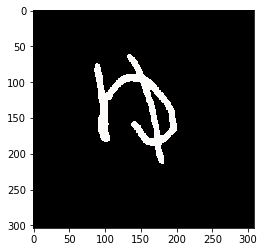

after reading image (308, 304)
final size torch.Size([1, 3, 64, 64])


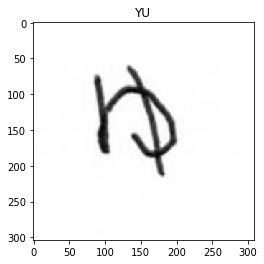

PREDICTION: ゆ


In [17]:
if __name__ == '__main__':
    
    net = Net()
    to_device(net, device)
    
    #for training
    #start_time = time.time()
    #train(net)
    #predict_sample(net)
    #print('Elapsed time: {:.3f} [sec]'.format(time.time() - start_time))
    
    #for predicting a single image
    if device.type == 'cpu':
        state_dict = torch.load('/Users/binhna/Downloads/model.pth', map_location=lambda storage, loc: storage)
    else:
        state_dict = torch.load('/Users/binhna/Downloads/model.pth')
    net.load_state_dict(state_dict)
    net.eval()
    
    # IMPORTANCE!!! args are: 
    #the model
    #image path
    #if the original image is not bin ==> bin should be TRUE
    # if the original image background is in white ==> black should be True 
    
    predict(net, '/Users/binhna/Desktop/test18.png', True, True)